# Assignment 3: Policy Gradients (DDPG and REINFORCE)

Name:

ID:

## Background
This exercise requires you to solve various continous control problems in OpenAI-Gym.  

DDPG is policy gradient actor critic method for continous control which is off policy. It tackles the curse of dimensionality / loss of performance faced when discretizing a continous action domain. DDPG uses similiar "tricks" as DQN to improve the stability of training, including a replay buffer and target networks.

Furthermore, you will implement REINFORCE for discrete and continous environments, and as a bonus compare the sample efficiency and performance with DQN and DDPG.


### DDPG paper: https://arxiv.org/pdf/1509.02971.pdf

### Environments:

#### InvertedPendulum-v2 environment:
<img src="inverted_pendulum.png" width="300">

#### Pendulum-v0 environment:
<img src="pendulum.png" width="300">

#### Halfcheetah-v2 environment:
<img src="half_cheetah.png" width="300">



### Setup environment for Actor Critic
- inline plotting
- gym
- directory for logging videos

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time

#environment
import gym

#pytorch
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

### Implement an action normalization class:
To train across various environments, it is useful to normalize action inputs and outputs between [-1, 1]. This class should take in actions and implement forward and reverse functions to map actions between [-1, 1] and [action_space.low, action_space.high].

Using the following gym wrapper, implement this class.
- https://github.com/openai/gym/blob/78c416ef7bc829ce55b404b6604641ba0cf47d10/gym/core.py
- i.e. we are overriding the outputs scale of actions. 

In [37]:
class NormalizeAction(gym.ActionWrapper):
    def _action(self, action):
        #tanh outputs (-1,1) from tanh, need to be [action_space.low, action_space.high]
        act_k = (self.action_space.high - self.action_space.low)/ 2.
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k * action + act_b

    def _reverse_action(self, action):
        #reverse of that above
        act_k_inv = 2./(self.action_space.high - self.action_space.low)
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k_inv * (action - act_b)

### Set up gym environment
The code below does the following for you:
- Wrap environment, log videos, setup CUDA variables (if GPU is available)
- Record action and observation space dimensions
- Fix random seed for determinisitic training

In [49]:
VISUALIZE = True
SEED = 0
MAX_PATH_LENGTH = 200
NUM_EPISODES = 12000
GAMMA=0.99
BATCH_SIZE = 128
logging_interval = 50
animate_interval = logging_interval * 5

# Environments to be tested on
#env_name = 'InvertedPendulum-v1'
env_name = 'Pendulum-v0'
#env_name = 'HalfCheetah-v1' 
logdir='./DDPG/'+env_name

# wrap gym to save videos
env = NormalizeAction(gym.make(env_name))

if VISUALIZE:
    if not os.path.exists(logdir):
        os.mkdir(logdir)
    env = gym.wrappers.Monitor(env, logdir, force=True, video_callable=lambda episode_id: episode_id%logging_interval==0)
#env._max_episode_steps = MAX_PATH_LENGTH

# check observation and action space
discrete = isinstance(env.action_space, gym.spaces.Discrete)
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n if discrete else env.action_space.shape[0]

if discrete:
    print("This is a discrete action space, probably not the right algorithm to use")

# set random seeds
torch.manual_seed(SEED)
np.random.seed(SEED)

# make variable types for automatic setting to GPU or CPU, depending on GPU availability
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

def to_numpy(var):
    return var.cpu().data.numpy() if use_cuda else var.data.numpy()

def to_tensor(x, volatile=False, requires_grad=True):
    x = torch.from_numpy(x).float()
    x = Variable(x, requires_grad=requires_grad).type(dtype=Tensor)
    return x

[2018-05-18 07:16:48,017] Making new env: Pendulum-v0
[2018-05-18 07:16:48,021] Clearing 14 monitor files from previous run (because force=True was provided)


### Demonstrate your understanding of the simulation:
For the environments mentioned above ('Pendulum-v0', 'HalfCheetah-v2', 'InvertedPendulum-v2'),
- describe the reward system
- describe the each state variable (observation space)
- describe the action space
- when is the environment considered "solved"?

Ans: 


# DDPG

### Write a weight syncing function
In contrast to DQN, DDPG uses soft weight sychronization. At each time step following training, the actor and critic target network weights are updated to track the rollout networks. 
- target_network.weights <= target_network.weights \* (1 - tau) + source_network.weights \* (tau)

In [50]:
def weightSync(target_model, source_model, tau = 0.001):
    for parameter_target, parameter_source in zip(target_model.parameters(), source_model.parameters()):
        parameter_target.data.copy_((1 - tau) * parameter_target.data + tau * parameter_source.data)

### Write a Replay class that includes all the functionality of a replay buffer
DDPG is an off policy actor-critic method and an identical replay buffer to that used for the previous assignment is applicable here as well (do not include the generate_minibatch method in your Replay class this time). Like before, your constructor for Replay should create an initial buffer of size 1000 when you instantiate it.

The replay buffer should kept to some maximum size (60000), allow adding of samples and returning of samples at random from the buffer. Each sample (or experience) is formed as (state, action, reward, next_state, done). 

In [51]:
import random

class Replay(object):
    def __init__(self, max_size):
        self.buffer = []
        self.capacity = max_size
        self.position = 0
        self.initialize(init_length=1000)
        
    def add_experience(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (np.asarray(state), action, reward,\
                                      np.asarray(next_state), done)
        self.position = (self.position+1)%self.capacity
    
    def initialize(self, init_length, env=env):
        state = env.reset()
        while True:
            action = np.random.uniform(-1.0, 1.0, size=env.action_space.shape)
            next_state, reward, done, _ = env.step(action)
            self.add_experience(state, action, reward, next_state, done)
            if done:
                state = env.reset()
                if len(self.buffer)>=init_length:
                    break
            else:
                state = next_state
    
    def sample(self, batch_size):
        states = []
        actions = []
        rewards = []
        next_states = []
        terminates = []
        samples = random.sample(self.buffer, batch_size)
        for state, action, reward, next_state, done in samples:
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            terminates.append(done)
        
        states = np.array(states, dtype=np.float).reshape(batch_size,-1)
        actions = np.array(actions, dtype=np.float).reshape(batch_size,-1)
        rewards = np.array(rewards, dtype=np.float).reshape(batch_size,-1)
        next_states = np.array(next_states, dtype=np.float).reshape(batch_size,-1)
        terminates = np.array(terminates, dtype=np.float).reshape(batch_size,-1)
        return states, actions, rewards, next_states, terminates

### Write an Ornstein Uhlenbeck process class for exploration noise
The proccess is described here:
- https://en.wikipedia.org/wiki/Ornstein–Uhlenbeck_process
- http://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab

You should implement:
- a step / sample method
- reset method

Use theta = 0.15, mu = 0, sigma = 0.3, dt = 0.01

In [52]:
class OrnsteinUhlenbeckProcess(object):
    def __init__(self, dimension, num_steps, theta=0.25, mu=0.0, sigma=0.05, dt=0.01):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x = np.zeros((dimension,))
        self.iter = 0
        self.num_steps = num_steps
        self.dimension = dimension
        self.min_epsilon = 0.01 # minimum exploration probability
        self.epsilon = 1.0
        self.decay_rate = 5.0/num_steps # exponential decay rate for exploration prob
    
    def sample(self):
        self.x = self.x + self.theta*(self.mu-self.x)*self.dt + \
                                       self.sigma*np.sqrt(self.dt)*np.random.normal(size=self.dimension)
        return self.epsilon*self.x
    
    def reset(self):
        self.x = 0*self.x
        self.iter += 1
        self.epsilon = self.min_epsilon + (1.0 - self.min_epsilon)*np.exp(-self.decay_rate*self.iter)

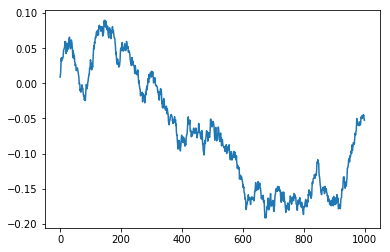

In [53]:
noise = OrnsteinUhlenbeckProcess(dimension=1,num_steps=1000)
y = np.zeros((1000))
for i in range(1000):
    y[i] = noise.sample()
plt.plot(range(1000),y)

### Write a Deep Neural Network class that creates a dense network of a desired architecture for actor and critic networks


#### Actor
- input and hidden layer activation function: ReLU

- output activation function: Tanh

- hidden_state sizes: 400

- state and action sizes: variable

- number of hidden layers: 2

- batch normalization applied to all hidden layers

- weight initialization: normal distribution with small variance. 

#### Critic
- input and hidden layer activation function: ReLU

- output activation function: None

- hidden_state sizes: 300, 300 + action size

- state and action sizes: variable

- number of hidden layers: 2

- batch normalization applied to all hidden layers prior to the action input

- weight initialization: normal distribution with small variance.

Good baselines can be found in the paper.

In [54]:
# ----------------------------------------------------
# actor model, MLP
# ----------------------------------------------------
# 2 hidden layers, 400 units per layer, tanh output to bound outputs between -1 and 1
def fanin_init(size, fanin=None):
    fanin = fanin or size[0]
    v = 1. / np.sqrt(fanin)
    return torch.Tensor(size).normal_(0.0, v)

class actor(nn.Module):
    def __init__(self, input_size, output_size):
        super(actor, self).__init__()
        self.fc1 = nn.Linear(input_size, 400)
        self.bn1 = nn.BatchNorm1d(400)
        self.fc2 = nn.Linear(400, 400)
        self.bn2 = nn.BatchNorm1d(400)
        self.fc3 = nn.Linear(400, output_size)
        self.init_weights()
    
    def init_weights(self, init_w=10e-3):
        self.fc1.weight.data = fanin_init(self.fc1.weight.data.size())
        self.fc2.weight.data = fanin_init(self.fc2.weight.data.size())
        self.fc3.weight.data.normal_(0, 3e-3)

    def forward(self, state):
        out = self.fc1(state)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out = F.relu(out)
        action = F.tanh(self.fc3(out))
        return action


# ----------------------------------------------------
# critic model, MLP
# ----------------------------------------------------
# 2 hidden layers, 300 units per layer, ouputs rewards therefore unbounded
# Action not to be included until 2nd layer of critic (from paper). Make sure 
# to formulate your critic.forward() accordingly

class critic(nn.Module):
    def __init__(self, state_size, action_size, output_size):
        super(critic, self).__init__()
        self.fc1 = nn.Linear(state_size, 300)
        #self.bn1 = nn.BatchNorm1d(300)
        self.fc2 = nn.Linear(300 + action_size, 300)
        self.fc3 = nn.Linear(300, output_size)
        self.init_weights()
    
    def init_weights(self, init_w=10e-3):
        self.fc1.weight.data = fanin_init(self.fc1.weight.data.size())
        self.fc2.weight.data = fanin_init(self.fc2.weight.data.size())
        self.fc3.weight.data.normal_(0, 3e-4)
        
    def forward(self, state, action):
        out = self.fc1(state)
        #out = self.bn1(out)
        out = F.relu(out)
        out = F.relu(self.fc2(torch.cat([out,action],1)))
        qvalue = self.fc3(out)
        return qvalue

### Define DDPG class to encapsulate definition, rollouts, and training

- gamma = 0.99

- actor_lr = 1e-4

- critic_lr = 1e-3

- critic l2 regularization = 1e-2

- noise decay

- noise class

- batch_size = 128

- optimizer: Adam

- loss (critic): mse

Furthermore, you can experiment with action versus parameter space noise. The standard implimentation works with action space noise, howeve parameter space noise has shown to produce excellent results.


In [55]:
OBS_DIM = env.observation_space.shape[0]
ACT_DIM = env.action_space.shape[0]

In [56]:
class DDPG:
    def __init__(self, obs_dim, act_dim, critic_lr = 1e-3, actor_lr = 1e-4, gamma = 0.99, alpha_decay=0.93, batch_size = 64):
        
        self.gamma = gamma
        self.batch_size = batch_size
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        
        # actor
        self.actor = actor(input_size = obs_dim, output_size = act_dim).type(FloatTensor)
        self.actor.cuda()
        self.actor_target = actor(input_size = obs_dim, output_size = act_dim).type(FloatTensor)
        self.actor_target.cuda()
        self.actor_target.load_state_dict(self.actor.state_dict())

        # critic
        self.critic = critic(state_size = obs_dim, action_size = act_dim, output_size = 1).type(FloatTensor)
        self.critic.cuda()
        self.critic_target = critic(state_size = obs_dim, action_size = act_dim, output_size = 1).type(FloatTensor)
        self.critic_target.cuda()
        self.critic_target.load_state_dict(self.critic.state_dict())

        # optimizers
        self.optimizer_actor = torch.optim.Adam(self.actor.parameters(), lr = actor_lr)
        self.optimizer_critic = torch.optim.Adam(self.critic.parameters(), lr = critic_lr, weight_decay=1e-2)
        
        # learning rate scheduler
        self.scheduler_actor = optim.lr_scheduler.StepLR(self.optimizer_actor, step_size=5000, gamma=alpha_decay)
        self.scheduler_critic = optim.lr_scheduler.StepLR(self.optimizer_critic, step_size=5000, gamma=alpha_decay)
        
        
        # critic loss
        self.critic_loss = nn.MSELoss()
        
        # noise
        self.noise = OrnsteinUhlenbeckProcess(dimension = act_dim, num_steps = NUM_EPISODES)

        # replay buffer 
        self.replayBuffer = Replay(60000)
        
        
    def train(self):
     
        # sample from Replay
        states, actions, rewards, next_states, terminates = self.replayBuffer.sample(self.batch_size)

        # update critic (create target for Q function)
        target_qvalues = self.critic_target(to_tensor(next_states, volatile=True),\
                                           self.actor_target(to_tensor(next_states, volatile=True)))
        #target_qvalues.volatile = False
        y = to_numpy(to_tensor(rewards) +\
            self.gamma*to_tensor(1-terminates)*target_qvalues)

        q_values = self.critic(to_tensor(states),
                               to_tensor(actions))
        qvalue_loss = self.critic_loss(q_values, to_tensor(y, requires_grad=False))
        
               
        # critic optimizer and backprop step (feed in target and predicted values to self.critic_loss)
        self.critic.zero_grad()
        qvalue_loss.backward()
        self.optimizer_critic.step()
        self.scheduler_critic.step()
        

        # update actor (formulate the loss wrt which actor is updated)
        policy_loss = -self.critic(to_tensor(states),\
                                 self.actor(to_tensor(states)))
        policy_loss = policy_loss.mean()
        

        # actor optimizer and backprop step (loss_actor.backward())
        self.actor.zero_grad()
        policy_loss.backward()
        self.optimizer_actor.step()
        self.scheduler_actor.step()
        
        # sychronize target network with fast moving one
        weightSync(self.critic_target, self.critic)
        weightSync(self.actor_target, self.actor)
        

### Create an instance of your DDPG object
- Print network architectures, confirm they are correct

In [57]:
ddpg = DDPG(obs_dim=OBS_DIM, act_dim=ACT_DIM, gamma=GAMMA, batch_size=BATCH_SIZE)
print(ddpg.actor)
print(ddpg.critic)

[2018-05-18 07:16:51,528] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/DDPG/Pendulum-v0/openaigym.video.3.221.video000000.mp4


actor(
  (fc1): Linear(in_features=3, out_features=400, bias=True)
  (bn1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=400, out_features=400, bias=True)
  (bn2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=400, out_features=1, bias=True)
)
critic(
  (fc1): Linear(in_features=3, out_features=300, bias=True)
  (fc2): Linear(in_features=301, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)


### Train DDPG on different environments
Early stopping conditions:
- avg_val > 500 for "InvertedPendulum" 
- avg_val > -150 for "Pendulum" 
- avg_val > 1500 for "HalfCheetah" 



In [59]:
avg_val = 0

#for plotting
running_rewards_ddpg = []
step_list_ddpg = []
step_counter = 0

# set term_condition for early stopping according to environment being used
term_condition = -150 # Pendulum

reached = False

for itr in range(NUM_EPISODES):
    state = env.reset() # get initial state
    animate_this_episode = (itr % animate_interval == 0) and VISUALIZE
    ddpg.noise.reset()
    step = 0
    total_reward = 0

    while True:
        if animate_this_episode:
                env.render()
                time.sleep(0.05)

        # use actor to get action, add ddpg.noise.step() to action
        # remember to put NN in eval mode while testing (to deal with BatchNorm layers) and put it back 
        # to train mode after you're done getting the action
        ddpg.actor.eval()
        state = state.reshape(1,-1)
        noise = ddpg.noise.sample()
        action = to_numpy(ddpg.actor(to_tensor(state))).reshape(-1,) + noise
        if not reached:
            ddpg.actor.train()
                
        # step action, get next state, reward, done (keep track of total_reward)
        # populate ddpg.replayBuffer
        next_state, reward, done, _ = env.step(action)
        ddpg.replayBuffer.add_experience(state.ravel(), action, reward, next_state, done)
        total_reward += reward

        ddpg.train()
        step_counter += 1
        
        if done:
            break

        state = next_state
        step+=1
    
    print(step_counter, total_reward)

    if avg_val > term_condition and itr>10:
        reached = True
    
    if reached and itr%logging_interval==1:
        break

    running_rewards_ddpg.append(total_reward) # return of this episode
    step_list_ddpg.append(step_counter)

    avg_val = avg_val * 0.95 + 0.05*running_rewards_ddpg[-1]
    print("Average value: {} for episode: {}".format(avg_val,itr))
    itr+=1


200 -1370.5738113640298
Average value: -68.5286905682015 for episode: 0
400 -1184.9885030854368
Average value: -124.35168119406326 for episode: 1
600 -1536.0860384473199
Average value: -194.9383990567261 for episode: 2
800 -1405.9003905013572
Average value: -255.48649862895763 for episode: 3
1000 -1546.9180518766912
Average value: -320.0580762913443 for episode: 4
1200 -1397.2081432807818
Average value: -373.9155796408162 for episode: 5
1400 -1300.7063079265288
Average value: -420.2551160551018 for episode: 6
1600 -1491.302146887883
Average value: -473.8074675967408 for episode: 7
1800 -1525.2012523294475
Average value: -526.3771568333761 for episode: 8
2000 -1451.8703934363787
Average value: -572.6518186635262 for episode: 9
2200 -1419.7598199078557
Average value: -615.0072187257427 for episode: 10
2400 -1480.669271671355
Average value: -658.2903213730233 for episode: 11
2600 -1388.8256611258932
Average value: -694.8170883606667 for episode: 12
2800 -1423.6297673928368
Average value: 

[2018-05-18 07:20:01,694] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/DDPG/Pendulum-v0/openaigym.video.3.221.video000050.mp4


8400 -972.1382964280394
Average value: -1143.482481907318 for episode: 41
8600 -789.0923074537203
Average value: -1125.7629731846382 for episode: 42
8800 -662.6023695940953
Average value: -1102.6049430051112 for episode: 43
9000 -672.122781687171
Average value: -1081.0808349392141 for episode: 44
9200 -692.9106598827914
Average value: -1061.6723261863929 for episode: 45
9400 -1453.0874319119202
Average value: -1081.2430814726692 for episode: 46
9600 -685.4092838046939
Average value: -1061.4513915892703 for episode: 47
9800 -916.7569265653698
Average value: -1054.2166683380754 for episode: 48
10000 -1285.5004225887149
Average value: -1065.7808560506073 for episode: 49
10200 -990.2551969628896
Average value: -1062.0045730962215 for episode: 50
10400 -1053.4107163178437
Average value: -1061.5748802573025 for episode: 51
10600 -983.4072064908702
Average value: -1057.6664965689808 for episode: 52
10800 -1145.58948388021
Average value: -1062.0626459345422 for episode: 53
11000 -1224.01664773

[2018-05-18 07:21:09,466] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/DDPG/Pendulum-v0/openaigym.video.3.221.video000100.mp4


18400 -143.81588806044218
Average value: -423.69011616061044 for episode: 91
18600 -135.87767574656374
Average value: -409.29949413990806 for episode: 92
18800 -145.56195676004157
Average value: -396.1126172709147 for episode: 93
19000 -10.156930862120726
Average value: -376.814832950475 for episode: 94
19200 -284.7749306836489
Average value: -372.2128378371337 for episode: 95
19400 -137.1466899229552
Average value: -360.45953044142476 for episode: 96
19600 -138.11035059004368
Average value: -349.3420714488557 for episode: 97
19800 -137.87667034778443
Average value: -338.7688013938021 for episode: 98
20000 -17.71542166983977
Average value: -322.716132407604 for episode: 99
20200 -136.00971358125855
Average value: -313.38081146628673 for episode: 100
20400 -140.10478657599413
Average value: -304.71701022177206 for episode: 101
20600 -133.16841545514205
Average value: -296.1395804834405 for episode: 102
20800 -138.04858121904755
Average value: -288.23503052022085 for episode: 103
21000 -

[2018-05-18 07:22:14,228] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/DDPG/Pendulum-v0/openaigym.video.3.221.video000150.mp4


28400 -124.43970876202759
Average value: -149.01413536606123 for episode: 141
28600 -369.3279018214439
Average value: -160.02982368883036 for episode: 142
28800 -131.89869240473456
Average value: -158.62326712462556 for episode: 143
29000 -134.81691260620133
Average value: -157.43294939870435 for episode: 144
29200 -234.97013804091574
Average value: -161.30980883081492 for episode: 145
29400 -118.4357039178567
Average value: -159.16610358516698 for episode: 146
29600 -122.67089451982228
Average value: -157.34134313189975 for episode: 147
29800 -0.6420312248829001
Average value: -149.50637753654888 for episode: 148
30000 -133.95849555472827
Average value: -148.72898343745783 for episode: 149
30200 -248.30474679107516
Average value: -153.70777160513867 for episode: 150
30400 -3.3519829033852164


## Plot rewards over multiple training runs 
This is provided to generate and plot results for you.

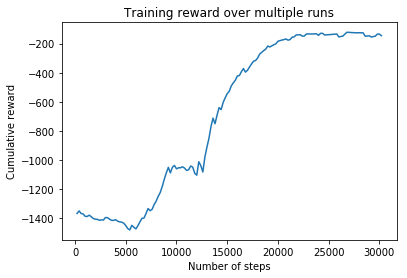

In [60]:
def numpy_ewma_vectorized_v2(data, window):

    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha
    n = data.shape[0]

    pows = alpha_rev**(np.arange(n+1))

    scale_arr = 1/pows[:-1]
    offset = data[0]*pows[1:]
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

plt.figure()
out = numpy_ewma_vectorized_v2(np.array(running_rewards_ddpg),20)
step_list_ddpg = np.array(step_list_ddpg)

plt.plot(step_list_ddpg, out)
plt.title('Training reward over multiple runs')
plt.xlabel('Number of steps')
plt.ylabel('Cumulative reward')
plt.show()

# REINFORCE

In this section you will implement REINFORCE, with modifications for batch training. It will be for use on both discrete and continous action spaces.

## Policy Parametrization

Define a MLP which outputs a distribution over the action preferences given input state. For the discrete case, the MLP outputs the likelihood of each action (softmax) while for the continuous case, the output is the mean and standard deviation parametrizing the normal distribution from which the action is sampled.



In [ ]:
# ----------------------------------------------------
# Policy parametrizing model, MLP
# ----------------------------------------------------
# 1 or 2 hidden layers with a small number of units per layer (similar to DQN)
# use ReLU for hidden layer activations
# softmax as activation for output if discrete actions, linear for continuous control
# for the continuous case, output_dim=2*act_dim (each act_dim gets a mean and std_dev)

class mlp(nn.Module):
    __init__(self, )

Define a function that samples an action from the policy distribtion parameters obtained as output of the MLP. The function should return the action and the log-probability (log_odds) of taking that action. 

In [ ]:
def sample_action(logit, discrete):
    # logit is the output of the softmax/linear layer
    # discrete is a flag for the environment type
    # Hint: use Categorical and Normal from torch.distributions to sample action and get the log-probability
    # Note that log_probability in this case translates to ln(\pi(a|s)) 
           
    return action, log_odds


Create a function update_policy that defines the loss function and updates the MLP according to the REINFORCE update rule (ref. slide 24 of Lec 7 or page 330 of Sutton and Barto (2018)). The update algorithm to be used below is slightly different: instead of updating the network at every time-step, we take the gradient of the loss averaged over a batch of timesteps (this is to make SGD more stable). We also use a baseline to reduce variance. 

The discount factor is set as 1 here. 


In [ ]:
def update_policy(paths, net):
    # paths: a list of paths (complete episodes, used to calculate return at each time step)
    # net: MLP object

    
    num_paths = len(paths)
    rew_cums = []
    log_odds = []
    
    for path in paths:
         # rew_cums should record return at each time step for each path 
         
         # log_odds should record log_odds obtained at each timestep of path
         
         # calculated as "reward to go"
            
    rew_cums = (rew_cums - rew_cums.mean()) / (rew_cums.std() + 1e-5) # create baseline
    
    # make log_odds, rew_cums each a vector
        
    # calculate policy loss and average over paths
    
    # take optimizer step
   

Set up environment and instantiate objects. Your algorithm is to be tested on one discrete and two continuous environments. 



In [ ]:
# Select Environment

#discrete environment:
#env_name='CartPole-v0'

#continous environments:
#env_name='InvertedPendulum-v2'
#env_name = 'HalfCheetah-v2'

env_name='InvertedPendulum-v2'

# Make the gym environment
env = gym.make(env_name)
visualize = False
animate=visualize

learning_rate = 1e-3

max_path_length=None


# Set random seeds
seed=0
torch.manual_seed(seed)
np.random.seed(seed)

# Saving parameters
logdir='./REINFORCE/'


if visualize:
    if not os.path.exists(logdir):
        os.mkdir(logdir)
    env = wrappers.Monitor(env, logdir, force=True, video_callable=lambda episode_id: episode_id%animate_interval==0)
env._max_episode_steps = min_timesteps_per_batch


# Is this env continuous, or discrete?
discrete = isinstance(env.action_space, gym.spaces.Discrete)

# Get observation and action space dimensions
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n if discrete else env.action_space.shape[0]

# Maximum length for episodes
max_path_length = max_path_length or env.spec.max_episode_steps

# Make network object (remember to pass in appropriate flags for the type of action space in use)
# net = mlp(*args)

# Make optimizer
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)

## Run REINFORCE

Run REINFORCE for CartPole, InvertedPendulum, and HalfCheetah. 

In [ ]:
n_iter = 1000 
min_timesteps_per_batch = 2000  # sets the batch size for updating network
avg_reward = 0
avg_rewards = []
step_list_reinforce = []
total_steps = 0
episodes = 0

for itr in range(n_iter): # loop for number of optimization steps
    paths = []
    steps = 0
    
    while True: # loop to get enough timesteps in this batch --> if episode ends this loop will restart till steps reaches limit
        ob = env.reset()
        obs, acs, rews, log_odds = [], [], [], [] 
       
        while True: # loop for episode inside batch
            if animate_this_episode:
                env.render()
                time.sleep(0.05)
            
            # get parametrized policy distribution from net using current state ob
            
            # sample action and get log-probability (log_odds) from distribution
            
            # step environment, record reward, next state
            
            # append to obs, acs, rewards, log_odds
            
            # if done, restart episode till min_timesteps_per_batch is reached
                     
            steps += 1
            
            if done:
                episodes = episodes + 1
                break
                
        path = {"observation" : obs, 
                "reward" : np.array(rews), 
                "action" : (acs),
                "log_odds" : log_odds}
        
        paths.append(path)
        
        if steps > min_timesteps_per_batch:
            break 
        
    update_policy(paths, net)  # use all complete episodes (a batch of timesteps) recorded in this itr to update net
    
    if itr == 0:
        avg_reward = path['reward'].sum()
    else:
        avg_reward = avg_reward * 0.95 + 0.05 * path['reward'].sum()
    
    if avg_reward > 300:
        break
    
    total_steps += steps
    avg_rewards.append(avg_reward)
    step_list_reinforce.append(total_steps)
    if itr % logging_interval == 0:
        print('Average reward: {}'.format(avg_reward))
   
      
env.close()

plt.plot(avg_rewards)
plt.title('Training reward for <env> over multiple runs ')
plt.xlabel('Iteration')
plt.ylabel('Average reward')

# BONUS (15% extra)

Compare average returns for CartPole (discrete action space) when using REINFORCE and DQN. Since in REINFORCE we update the network after a set number of steps instead of after every episode, plot the average rewards as a function of steps rather than episodes for both DQN and REINFORCE. You will need to make minor edits to your DQN code from the previous assignment to record average returns as a function of time_steps.

Similarly, compare REINFORCE with DDPG on InvertedPendulum and HalfCheetah using steps for the x-axis.

You may use the example code provided below as a reference for the graphs.


In [ ]:
 # import your DQN and format your average returns as defined above

In [ ]:
plt.figure()

out = numpy_ewma_vectorized_v2(np.array(running_rewards_ddpg),20)
plt.plot(step_list_ddpg, out) # or plt.plot(step_list_DQN, out)
plt.title('Training reward over multiple runs')
plt.xlabel('Number of steps')
plt.ylabel('Cumulative reward')
plt.legend(['DDPG', 'REINFORCE']) #or plt.legend(['DQN', 'REINFORCE'])
plt.plot(step_list_reinforce, avg_rewards)

plt.show()